### Бутстрап

Под бутстрапом обычно понимется непараметрический метод получения дисперсии оценки на основе симуляций. Прдеставим, что у нас имеется выборка размера $n$:
$$X_1, ..., X_n \sim F$$
и мы хотим посчитать некоторую статистику: 
$$ \hat{\theta} = T (F_n).$$

Бутстрап будет заключаться в том, что мы возьмем выборку размера $m$ из эмпирической функции распределения:
$$x_1^*, ..., x_m^*,$$
полученной с повторением из исходного эмпирического распределения.

Для каждой бутстраповской выборки мы рассчитаем оценку:
$$ \hat{\theta}^{*} = T(F_n^{*}),$$

и приблизим разность между интересующим нас распределением:
$$ \hat{\theta} - \theta,$$
с помощью его бутстреп аналога:
$$ \hat{\theta}^* - \hat{\theta}.$$

In [18]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('data/old_faithful.txt', sep=',')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 0 to 271
Data columns (total 3 columns):
index        272 non-null int64
eruptions    272 non-null float64
waiting      272 non-null int64
dtypes: float64(1), int64(2)
memory usage: 8.5 KB


In [4]:
median_initial = np.median(data['waiting'])

In [5]:
median_initial

76.0

In [6]:
errs = []
for i in xrange(1000):
    errs.append(median_initial-resample(data['waiting'], replace=True).median())

In [7]:
np.percentile(np.sort(errs), 95)

2.0

In [8]:
np.percentile(np.sort(errs), 5)

-1.0

Получаем следующий 0.1-доверительный интервал для оценки медианы: [77, 78]. Стандартная ошибка, соответственно, равна:

In [9]:
sum(map(lambda x: x**2, errs))/1000

1.0569999999999999

** Бутстрапирование персентелей напрямую ** - метод, который предполагает аппроксимацию не с помощию рецентрирования статистики и расчета ошибки, а напрямую из распределения оценок, полученных в ходе симуляций.

**Параметрический бутстрап** - на каждом шаге мы сэмплируем не из эмпирического распределения, а из некоторого теоретического распределения, описывающего генеральную совокупность.

### Джекнайф

Идея джекнайф оценки в следующем - мы последовательно исключаем наблюдение за наблюдением и строим оценку на **оставшейся** части, затем данные оценки усредняются по $n$.

In [10]:
def jackknife(x, func):
    n = len(x)
    idx = np.arange(n)
    return np.sum(func(x[idx!=i]) for i in range(n))/float(n)

In [11]:
x = np.random.normal(0, 2, 100)
jackknife(x, np.std)

1.8923322737117052

Оценка дисперсии статистики строится аналогично бутстрепу:
$$ V_{j} = \frac{n-1}{n} \sum_{i=1}^{n} (\hat{x}_i - \hat{x}_:)^2.$$

In [12]:
def jackknife_var(x, func):
    n = len(x)
    idx = np.arange(n)
    j_est = jackknife(x, func)
    return (n-1)/(n + 0.0) * np.sum((func(x[idx!=i]) - j_est)**2.0
                                    for i in range(n))

In [13]:
jackknife_var(x, np.std)

0.012882313596688523

### LOOCV

Дальнейшее развитие данные методы получили в машинном обучении. Похожий метод - кросс-валидация. Ключевое отличие: в джекнайфе статистика рассчитывается на основе выборки, которая осталась у нас на руках, в LOOCV - на основе наблюдений, которые мы исключили из расчета.

In [24]:
a, b, c = 1, 2, 3
x = np.linspace(0, 5, 10)
y = a*x**2 + b*x + c + np.random.normal(0, 1, len(x))

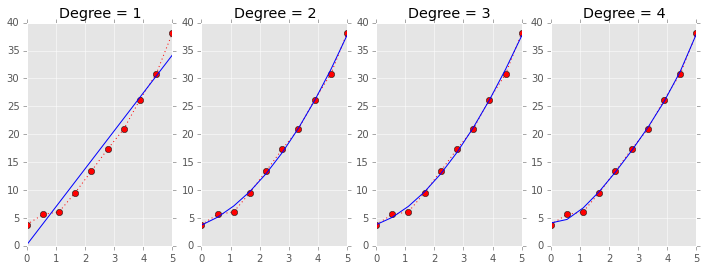

In [25]:
plt.figure(figsize=(12,4))
for deg in range(1, 5):
    plt.subplot(1, 4, deg)
    beta = np.polyfit(x, y, deg)
    plt.plot(x, y, 'r:o')
    plt.plot(x, np.polyval(beta, x), 'b-')
    plt.title('Degree = %d' % deg)

In [26]:
def loocv(x, y, fit, pred, deg):
    n = len(x)
    idx = np.arange(n)
    rss = np.sum([(y - pred(fit(x[idx!=i], y[idx!=i], deg), x))**2.0 for i in range(n)])
    return rss

In [27]:
for deg in range(1, 5):
    print 'Degree = %d, RSS=%.2f' % (deg, np.sum((y - np.polyval(np.polyfit(x, y, deg), x))**2.0))

Degree = 1, RSS=48.51
Degree = 2, RSS=2.83
Degree = 3, RSS=2.80
Degree = 4, RSS=1.96


In [28]:
for deg in range(1, 5):
    print 'Degree = %d, RSS=%.2f' % (deg, loocv(x, y, np.polyfit, np.polyval, deg))

Degree = 1, RSS=512.21
Degree = 2, RSS=30.04
Degree = 3, RSS=35.45
Degree = 4, RSS=47.39
